<a href="https://colab.research.google.com/github/kevinbecxrra/MINE4201_SR_Laboratorio_1/blob/main/MINE4201_SR_Laboratorio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MINE4201- SR -  Laboratorio 1
# Exploración modelos KNN



Vamos a utilizar las siguientes librerias en el laboratorio


In [1]:
!pip install numpy
!pip install scikit-surprise
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505190 sha256=92ba610336d4d388003e434a3bea36f32dba1914f04567eeacdab5ff6e12738d
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
pwd

'/content'

In [3]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)


## Suba al servidor los archivos u.data y u.item que se encuentran en el dataset descargado, en la pestaña files

In [4]:
if not (os.path.exists('/content/u.data') and os.path.exists('/content/u.item')):
  raise ValueError('Los archivos u.data e u.item no fueron encontrados en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [5]:
ratings=pd.read_csv('/content/u.data', sep = '\t', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ] )

In [6]:
items=pd.read_csv('/content/u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',
                                                          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                                                          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1' )

<ipython-input-6-0fd3a8730baf>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  items=pd.read_csv('/content/u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',


Verifique que los ratings y los items hayan sido cargados correctamente





In [7]:
#ratings.rating=ratings.rating.astype('category')
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Visualice la distribución de ratings, ¿Qué puede decir al respecto?

<Axes: >

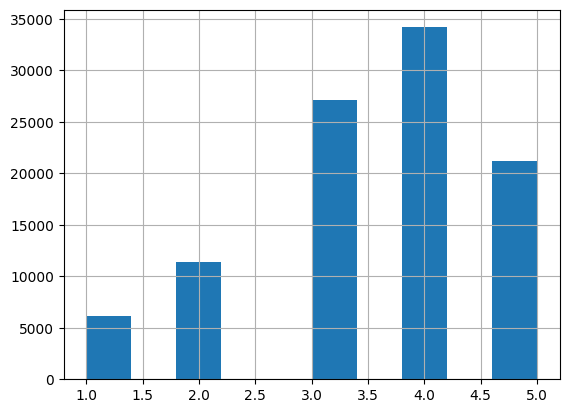

In [9]:
ratings.rating.hist()

La mayor cantidad de ratings están por encima de 4.0; mientras que hay muy pocos ratings por debajo de 3.0.

## En la siguiente celda se esta calculando el número de ratings por usuario y  el promedio de sus calificaciones, el dataframe esta ordenado por el número de calificaciones

In [10]:
user_ratings = ratings.groupby('user_id')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False)
user_ratings

,mean,count
user_id,,
405,1.834464,737
655,2.908029,685
13,3.097484,636
450,3.864815,540
276,3.465251,518
...,...,...
685,2.050000,20
475,3.600000,20
36,3.800000,20


In [11]:
user_count= user_ratings["count"]
user_count

,count
user_id,
405,737
655,685
13,636
450,540
276,518
...,...
685,20
475,20
36,20


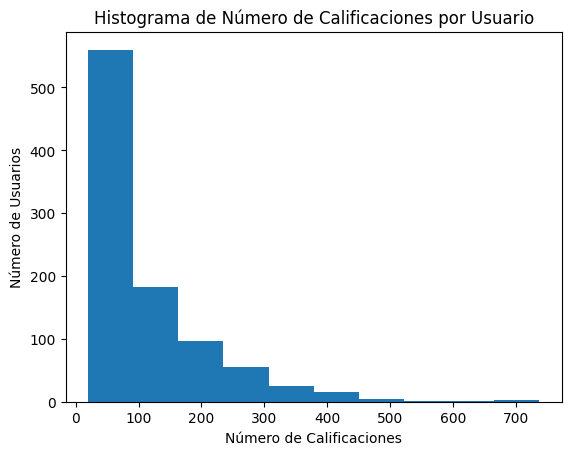

In [12]:
import matplotlib.pyplot as plt

plt.hist(user_count.values)
plt.xlabel("Número de Calificaciones")
plt.ylabel("Número de Usuarios")
plt.title("Histograma de Número de Calificaciones por Usuario")
plt.show()


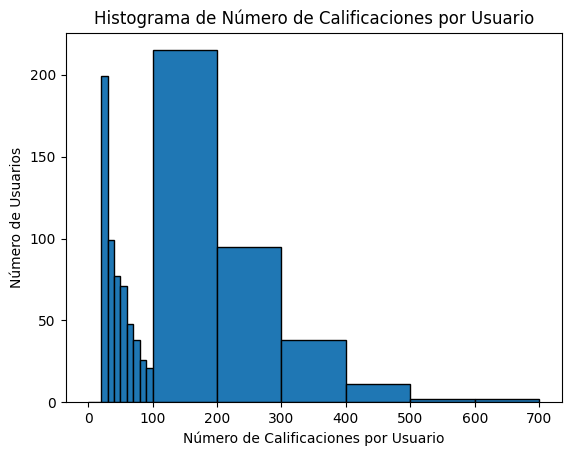

In [13]:
import matplotlib.pyplot as plt

# Define los rangos para el histograma
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700]

# Crea el histograma
plt.hist(user_count, bins=bins, edgecolor='black')

# Configura las etiquetas y el título
plt.xlabel('Número de Calificaciones por Usuario')
plt.ylabel('Número de Usuarios')
plt.title('Histograma de Número de Calificaciones por Usuario')

# Muestra el histograma
plt.show()

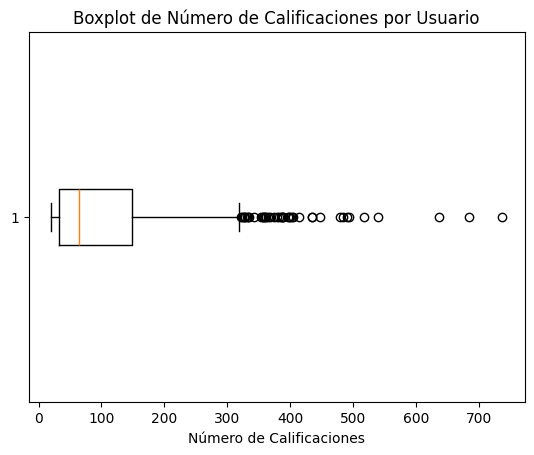

In [56]:
import matplotlib.pyplot as plt

# Create the box plot without considering the index
plt.boxplot(user_count.values, vert=False)  # Use .values to get the data as a NumPy array

# Add labels and title
plt.xlabel('Número de Calificaciones')
plt.title('Boxplot de Número de Calificaciones por Usuario')

# Show the plot
plt.show()


In [15]:
mean_ratings= user_ratings["mean"]
mean_ratings

,mean
user_id,
405,1.834464
655,2.908029
13,3.097484
450,3.864815
276,3.465251
...,...
685,2.050000
475,3.600000
36,3.800000


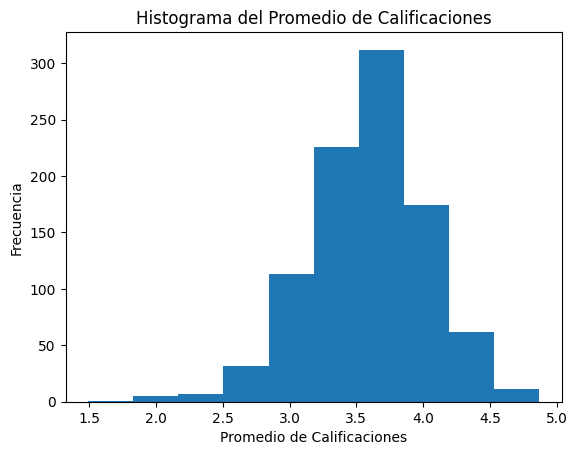

In [57]:
# prompt: creame un histograma de mean_rating sin tener en cuenta el indice

import matplotlib.pyplot as plt

# Create the histogram without considering the index
plt.hist(user_ratings['mean'], bins=10)  # You can adjust the number of bins

# Add labels and title
plt.xlabel('Promedio de Calificaciones')
plt.ylabel('Frecuencia')
plt.title('Histograma del Promedio de Calificaciones')

# Show the plot
plt.show()


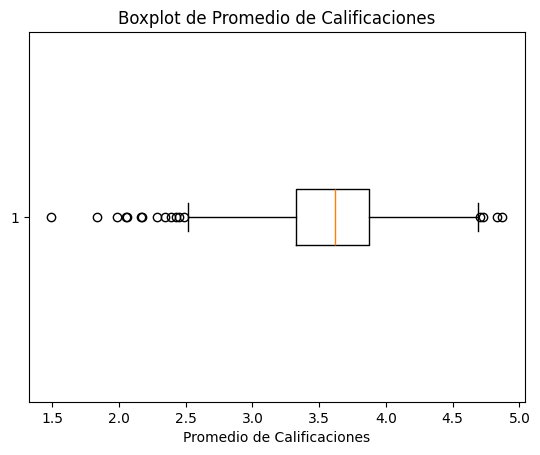

In [58]:
import matplotlib.pyplot as plt

# Assuming 'mean_rating' is a pandas Series or DataFrame column
# If it's a Series:
# plt.boxplot(mean_rating.values, vert=False)

# If it's a DataFrame column:
plt.boxplot(user_ratings['mean'].values, vert=False)


plt.xlabel('Promedio de Calificaciones')
plt.title('Boxplot de Promedio de Calificaciones')
plt.show()


In [59]:
kurtosis_mean_rating = user_ratings['mean'].kurtosis()
print(f"Kurtosis del promedio de calificaciones por usuario: {kurtosis_mean_rating}")

Kurtosis del promedio de calificaciones por usuario: 0.9400140287991934


In [19]:
ratings.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [20]:
import pandas as pd

# Assuming 'ratings' DataFrame is already loaded as in the provided code.

# Calculate the 90th percentile of the user ratings count
percentile_90 = user_ratings['count'].quantile(0.90)

print(f"El percentil 90 del conteo de calificaciones de los usuarios es: {percentile_90}")

# Describe the user ratings count
print("\nDescripción del conteo de calificaciones de los usuarios:")
print(user_ratings['count'].describe())

El percentil 90 del conteo de calificaciones de los usuarios es: 244.4000000000002

Descripción del conteo de calificaciones de los usuarios:
count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: count, dtype: float64


##Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

¿Cómo es la distribución del número de ratings por usuario?

¿Cómo es la distribución del promedio de calificación por usuario?


Frente al número de ratings por usuario, se puede decir que la gran mayoría de la población ha rankeado menos de 70 películas ya que el percentil 50% se encuentra en 65. De igual forma, se puede decir que es una distribución que se encuentra sesgada a la izquierda con muchos outliers grandes hacia la derecha.

Frente al promedio de número de calificaciones por usuario, se puede decir que tiene una distribución que empieza a acercarse a la normal pero tiene colas más pesadas que una distribución normal, lo que significa que hay presencia de outliers con más frecuencia; lo anterior de acuerdo al valor de la kurtosis (0.92).

##En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones.

In [21]:
mt=ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left').sort_values(by='count', ascending=False)
mt

,mean,count,var,movie title
item_id,,,,
50,4.358491,583,0.776762,Legends of the Fall (1994)
258,3.803536,509,0.988885,George of the Jungle (1997)
100,4.155512,508,0.952100,Heavy Metal (1981)
181,4.007890,507,0.853693,GoodFellas (1990)
294,3.156701,485,1.206799,Breakdown (1997)
...,...,...,...,...
1576,1.000000,1,NaN,"Death in the Garden (Mort en ce jardin, La) (1..."
1577,1.000000,1,NaN,"Collectionneuse, La (1967)"
1348,1.000000,1,NaN,Mille bolle blu (1993)


##Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuáles son los items con más calificaciones?  

¿Se puede observar el fenomeno de cola larga en este dataset?




             mean  count       var                  movie title
item_id                                                        
50       4.358491    583  0.776762   Legends of the Fall (1994)
258      3.803536    509  0.988885  George of the Jungle (1997)
100      4.155512    508  0.952100           Heavy Metal (1981)
181      4.007890    507  0.853693            GoodFellas (1990)
294      3.156701    485  1.206799             Breakdown (1997)
286      3.656965    481  1.367498         Marvin's Room (1996)
288      3.441423    478  1.240796                 Evita (1996)
1        3.878319    452  0.860992             GoldenEye (1995)
300      3.631090    431  0.996147              In & Out (1997)
121      3.438228    429  1.246759        Cable Guy, The (1996)


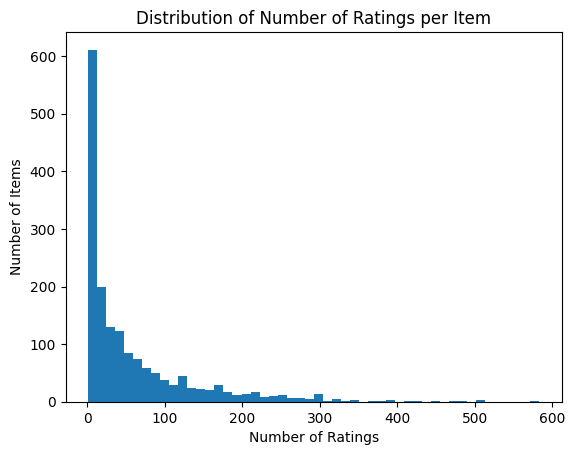

In [22]:
import matplotlib.pyplot as plt
# Assuming 'mt' DataFrame from the previous code is available.

# Sort the DataFrame by the 'count' column in descending order to find items with the most ratings.
top_rated_items = mt.sort_values(by='count', ascending=False)

# Display the top N items (e.g., top 10)
print(top_rated_items.head(10))

# Check for the long tail phenomenon:
# 1. Observe the distribution of 'count' (number of ratings per item)
#    A long tail would show that a small number of items receive a large number of ratings, while a large number of items receive few ratings.

# Display a histogram of the 'count' column to visualize the distribution
plt.hist(mt['count'], bins=50) # you can adjust the number of bins
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Items")
plt.title("Distribution of Number of Ratings per Item")
plt.show()


Los items con más calificaciones son Legends of the Fall, George of the Jungle, Heavy Metal, GoodFellas y Breakdown.

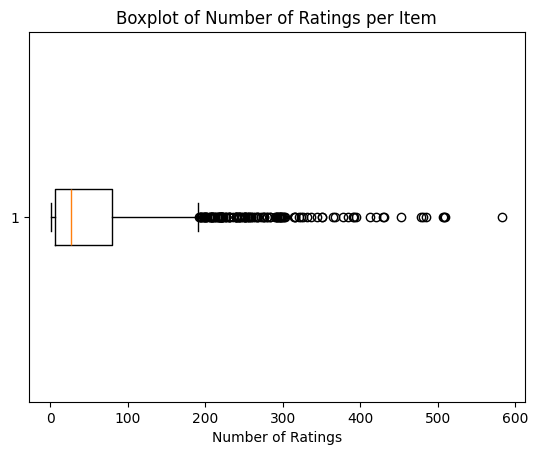

In [23]:
import matplotlib.pyplot as plt

# Assuming 'mt' DataFrame from the previous code is available.
# If not, make sure to run the code that creates 'mt' before this cell.

# Create the box plot of the number of ratings per item
plt.boxplot(mt['count'].values, vert=False)

# Add labels and title
plt.xlabel('Number of Ratings')
plt.title('Boxplot of Number of Ratings per Item')

# Show the plot
plt.show()

In [24]:
# Calculate the kurtosis of the number of ratings per item
kurtosis_item_ratings = mt['count'].kurtosis()
print(f"Kurtosis of the number of ratings per item: {kurtosis_item_ratings}")

# Calculate the kurtosis of the mean of ratings per item
kurtosis_item_ratings = mt['mean'].kurtosis()
print(f"Kurtosis of the mean of ratings per item: {kurtosis_item_ratings}")

Kurtosis of the number of ratings per item: 6.590762049772521
Kurtosis of the mean of ratings per item: 0.44910178186899063


De acuerdo con el boxplot y las kurtosis halladas se puede decir que sí se encuentra el fenómeno de cola larga ya que se presentan demasiados outliers hacia la derecha.

## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos son los mejores items del dataset.

¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

¿Es posible generar una mejor lista de recomendación teniendo en cuenta tanto el número de ratings del item como su promedio?

Ver:

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


In [25]:
# Assuming 'mt' DataFrame from the provided code is available.
# If not, make sure to run the code that creates 'mt' before this cell.

# Sort 'mt' by 'mean' (average rating) in descending order.
top_rated_movies = mt.sort_values(by='mean', ascending=False)

# Get the top 10 movie titles.
top_10_recommendations = top_rated_movies['movie title'].head(10).tolist()

# Print the top 10 recommendations.
top_10_recommendations

['Ayn Rand: A Sense of Life (1997)',
 'Cosi (1996)',
 'Guantanamera (1994)',
 'Last Time I Saw Paris, The (1954)',
 'Chairman of the Board (1998)',
 'One Fine Day (1996)',
 'That Old Feeling (1997)',
 'Maybe, Maybe Not (Bewegte Mann, Der) (1994)',
 'Cure, The (1995)',
 'Prisoner of the Mountains (Kavkazsky Plennik) (1996)']

Uno de los principales problemas de generar una lista no personalizada basada únicamente en el promedio es que la confiabilidad del promedio depende de la cantidad de calificaciones. Por ejemplo, un ítem con solo dos calificaciones de 5.0 podría aparecer en los primeros lugares, a pesar de que su promedio no sea representativo debido a la baja cantidad de evaluaciones. En contraste, un ítem con muchas calificaciones tendría un promedio más estable y confiable, pero podría quedar relegado en la lista si sus calificaciones, aunque consistentes, son ligeramente inferiores.

Sí, es posible generar una mejor lista de recomendación teniendo en cuenta tanto el número de calificaciones de un ítem como su promedio ya que se puede utilizar el intervalo de confianza de Wilson. En este caso, cuando un ítem tiene pocas calificaciones, su promedio puede ser engañosamente alto o bajo, por lo que con esta formula se proporciona una forma de calcular un límite inferior de confianza para la proporción de calificaciones positivas. De esta forma se ordena los ítems por su promedio y también ajusta los resultados en función de la cantidad de calificaciones, asegurando que los ítems con pocas calificaciones no dominen la lista injustamente, evitando de esta forma sesgos.

#Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise, para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [26]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [27]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [28]:
train_set.n_ratings

80000

In [29]:
len(test_set)

20000

In [30]:
#Este es el primer elemento del dataset de prueba (usuario 154, pelicula 302, rating 4)
test_set[0]

(154, 302, 4.0)

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html)

El modelo recibe los siguientes parámetros:


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [31]:
# se crea un modelo knnbasic item-item con similitud coseno
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [32]:
#Se le pasa la matriz de utilidad al algoritmo
algo.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

---



In [33]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False})

In [34]:
items[items['movie id']==302]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
301,302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [35]:
test_predictions=algo.test(test_set)

In [36]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [37]:
# En promedio, el sistema encuentra ratings que estan una estrella por encima o por debajo del rating del usuario
accuracy.rmse( test_predictions, verbose = True )

RMSE: 1.0453


1.0453343976192102

##Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ?

In [38]:
# se crea un modelo knnbasic item-item con similitud coseno
sim_options = {'name': 'cosine',
               'user_based': True  # calcule similitud item-item
               }
algo_user = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [39]:
#Se le pasa la matriz de utilidad al algoritmo
algo_user.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [40]:
#Verifique la propiedad est de la predicción
algo_user.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.35, details={'actual_k': 20, 'was_impossible': False})

In [41]:
test_predictions_user = algo_user.test(test_set)

In [42]:
test_predictions_user[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.35, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=4.350586293776335, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=3.607980194649977, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.6497107625654204, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=3.8002893050257525, details={'actual_k': 20, 'was_impossible': False})]

In [43]:
accuracy.rmse( test_predictions_user, verbose = True )

RMSE: 1.0166


1.0166414414593592

RMSE: 1.0453 (Modelo Item-Item)
En promedio, las predicciones del modelo están aproximadamente 1.045 estrellas por encima o por debajo del rating real del usuario.

RMSE: 1.0166 (Modelo Usuario-Usuario)
En promedio, las predicciones del modelo están aproximadamente 1.016 estrellas, lo que sugiere que es ligeramente más preciso que el modelo basado en ítems.

Como el RMSE del modelo usuario-usuario es menor (1.0166 vs. 1.0453), esto indica que, en este caso, el modelo basado en usuarios hace mejores predicciones que el modelo basado en ítems. Sin embargo, la diferencia es pequeña, por lo que ambos modelos tienen un desempeño similar.

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


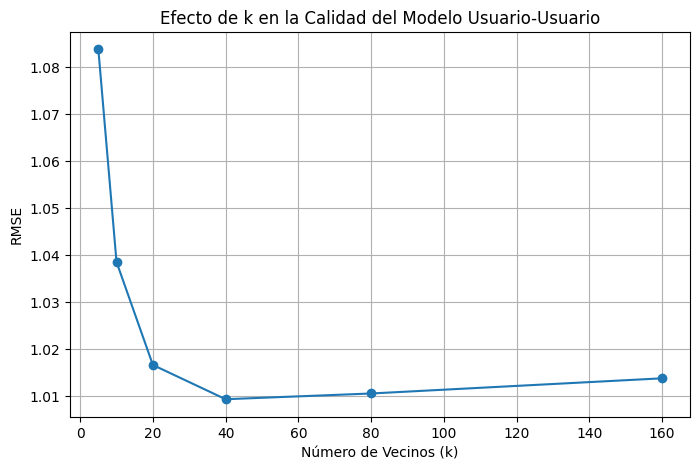

In [44]:
import matplotlib.pyplot as plt

k_values = [5, 10, 20, 40, 80, 160]  # Diferentes valores de k
rmse_scores = []

for k in k_values:
    algo = KNNBasic(k=k, min_k=2, sim_options={'name': 'cosine', 'user_based': True})
    algo.fit(trainset=train_set)
    predictions = algo.test(testset=test_set)
    rmse = accuracy.rmse(predictions, verbose=False)
    rmse_scores.append(rmse)

# Graficar RMSE vs Número de Vecinos
plt.figure(figsize=(8,5))
plt.plot(k_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Número de Vecinos (k)")
plt.ylabel("RMSE")
plt.title("Efecto de k en la Calidad del Modelo Usuario-Usuario")
plt.grid(True)
plt.show()

In [45]:
from surprise import KNNBasic, Dataset
from surprise.model_selection import GridSearchCV

# Definir los hiperparámetros a probar
param_grid = {
    'k': [5, 10, 20, 40, 80, 160],  # Diferentes valores de k
    'min_k': [1, 2, 5],  # Valores mínimos de vecinos
    'sim_options': {'name': ['cosine'], 'user_based': [True]}  # Usuario-Usuario con similitud coseno
}

# Crear la búsqueda en grid
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5, n_jobs=-1)

# Ejecutar búsqueda
gs.fit(surprise_dataset)

# Obtener el mejor modelo y sus hiperparámetros
best_params = gs.best_params['rmse']
best_rmse = gs.best_score['rmse']

print(f"Mejores parámetros: {best_params}")
print(f"Mejor RMSE obtenido: {best_rmse}")


Mejores parámetros: {'k': 80, 'min_k': 2, 'sim_options': {'name': 'cosine', 'user_based': True}}
Mejor RMSE obtenido: 1.0155638680918755


El efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario es que Un k pequeño puede generar predicciones menos precisas porque hay pocos datos de referencia y a su vez es más sensible al 'ruido' y un k muy grande puede incluir vecinos menos relevantes, aumentando el error y haciendo predicciones más genéricas.
Hay un punto óptimo de k, que minimiza el RMSE, que en este caso es 80 vecinos.

##Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [46]:
#Se crea el dataset para modelo
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [47]:
#10 primeras predicciones
predictions[0:10]

[Prediction(uid=196, iid=302, r_ui=3.52986, est=3.4998074068929244, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.52986, est=3.531852919263047, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=51, r_ui=3.52986, est=3.59549677885145, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=346, r_ui=3.52986, est=3.5471070543165877, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=474, r_ui=3.52986, est=3.7990088769026116, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=265, r_ui=3.52986, est=3.4464297466659812, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=465, r_ui=3.52986, est=3.5022156502733557, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=451, r_ui=3.52986, est=3.6948301041629965, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=86, r_ui=3.52986, e

In [48]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [49]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [50]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [51]:
user_predictions

[Prediction(uid=196, iid=1309, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1310, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1676, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1675, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1289, r_ui=3.52986, est=4.202435603862276, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1643, r_ui=3.52986, est=4.097225899300029, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1593, r_ui=3.52986, est=4.090909090909091, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid=196, iid=935, r_ui=3.52986, est=4.05136705364539, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1216, r_ui=3.52986, est=4.0506920732628675, details={'actual_k': 20, 'was_i

In [52]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [53]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1309,4.500000,"Very Natural Thing, A (1974)",http://us.imdb.com/M/title-exact?Very%20Natura...
1,1310,4.500000,"Walk in the Sun, A (1945)",http://us.imdb.com/M/title-exact?Walk%20in%20t...
2,1676,4.250000,"War at Home, The (1996)",http://us.imdb.com/M/title-exact?War%20at%20Ho...
3,1675,4.250000,"Sunchaser, The (1996)","http://us.imdb.com/M/title-exact?Sunchaser,%20..."
4,1289,4.202436,Jack and Sarah (1995),http://us.imdb.com/M/title-exact?Jack%20and%20...
5,1643,4.097226,Angel Baby (1995),http://us.imdb.com/Title?Angel+Baby+(1995/I)
6,1593,4.090909,Death in Brunswick (1991),http://us.imdb.com/M/title-exact?Death%20in%20...
7,935,4.051367,Paradise Road (1997),http://us.imdb.com/M/title-exact?Paradise%20Ro...
8,1216,4.050692,Kissed (1996),http://us.imdb.com/M/title-exact?Kissed%20%281...
9,1312,4.049247,"Pompatus of Love, The (1996)",http://us.imdb.com/M/title-exact?Pompatus%20of...


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

In [54]:
ratings['user_id'].max()+1

944